In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
import pickle
import torch
import numpy as np

from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs, stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [5]:
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# stack runs for each model
x, y, vars = stack_runs(x,y,vars)

# stack runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:111: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:153: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:157: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [6]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33)

In [7]:
# import algorithms

from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, train_robust_weights_model, compute_weights


In [8]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

Loss function:  318449.1138850524
Loss function:  345500.82303304394
Loss function:  490400.6625835947
Loss function:  545186.4922998112


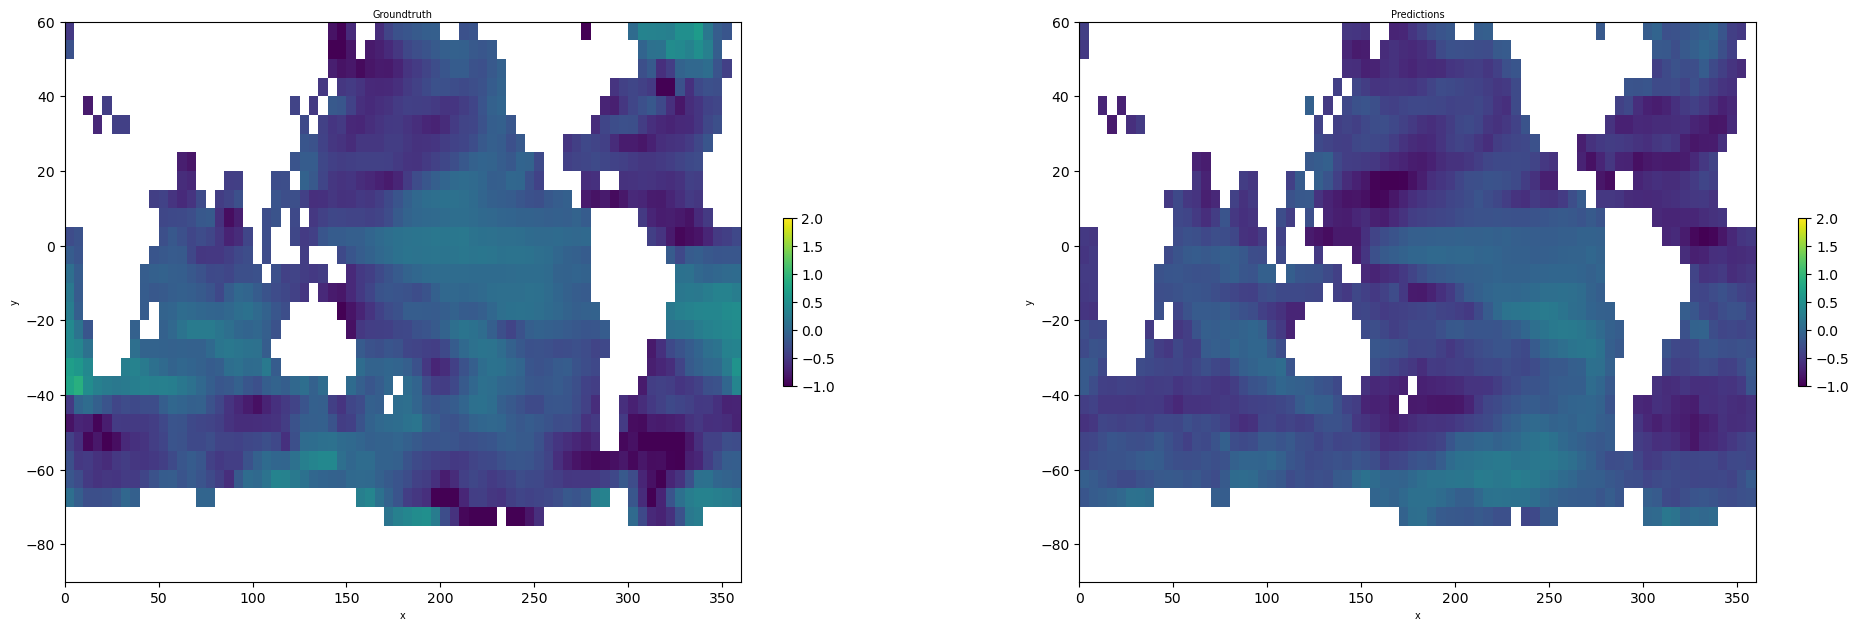

In [9]:
from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred

plot_gt_vs_pred(y_test,x_test,W_ridge,notnan_idx,nan_idx,lon_grid,lat_grid,time_idx=10)

In [10]:
w_robust, training_loss = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,\
                                                       rank=None,lambda_=100.0,mu_=1000.0,\
                                                       lr=1e-5,nb_iterations=20)

Iteration  0 : Loss function :  30670.474609375
Iteration  1 : Loss function :  25605.857421875
Iteration  2 : Loss function :  23240.486328125
Iteration  3 : Loss function :  21696.236328125
Iteration  4 : Loss function :  20302.904296875
Iteration  5 : Loss function :  18961.26953125
Iteration  6 : Loss function :  17710.21875
Iteration  7 : Loss function :  16603.578125
Iteration  8 : Loss function :  15671.99609375
Iteration  9 : Loss function :  14904.3193359375
Iteration  10 : Loss function :  14274.9921875
Iteration  11 : Loss function :  13757.783203125
Iteration  12 : Loss function :  13330.53125
Iteration  13 : Loss function :  12975.658203125
Iteration  14 : Loss function :  12679.05078125
Iteration  15 : Loss function :  12429.0791015625
Iteration  16 : Loss function :  12216.1484375
Iteration  17 : Loss function :  12032.4619140625
Iteration  18 : Loss function :  11871.798828125
Iteration  19 : Loss function :  11729.3076171875


In [11]:
weights = compute_weights(training_models,w_robust,x,y,notnan_idx,lambda_=1.0,mu_=1.0)

/home/vcohen/cope/src/algorithms.py:232: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


In [12]:
from leave_one_out import leave_one_out_single, leave_one_out_procedure

In [13]:
w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
                                         lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
                                         method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
                                         lr=1e-5,nb_gradient_iterations=5,verbose=True)

Iteration  0 : Loss function :  30670.474609375
Iteration  1 : Loss function :  25605.857421875
Iteration  2 : Loss function :  23240.486328125
Iteration  3 : Loss function :  21696.236328125
Iteration  4 : Loss function :  20302.904296875


In [14]:
w, rmse_mean, training_loss, weights = leave_one_out_procedure(x,y,vars,\
                                                            lon_size,lat_size, notnan_idx, nan_idx,time_period=33,\
                                                            method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
                                                            lr=1e-5,nb_gradient_iterations=5,verbose=True)

Iteration  0 : Loss function :  16267.587890625
Iteration  1 : Loss function :  13643.0439453125
Iteration  2 : Loss function :  12195.38671875
Iteration  3 : Loss function :  11598.857421875
Iteration  4 : Loss function :  11357.97265625
RMSE (mean) on model  ICON-ESM-LR  :  0.6858034909583546
Iteration  0 : Loss function :  30670.474609375
Iteration  1 : Loss function :  25605.859375
Iteration  2 : Loss function :  23240.513671875
Iteration  3 : Loss function :  21696.36328125
Iteration  4 : Loss function :  20303.44140625
RMSE (mean) on model  EC-Earth3  :  0.15347330152767377
Iteration  0 : Loss function :  30670.474609375
Iteration  1 : Loss function :  25605.857421875
Iteration  2 : Loss function :  23240.486328125
Iteration  3 : Loss function :  21696.236328125
Iteration  4 : Loss function :  20302.904296875
RMSE (mean) on model  CMCC-CM2-SR5  :  0.2772097157787544
Iteration  0 : Loss function :  30670.474609375
Iteration  1 : Loss function :  25605.853515625
Iteration  2 : Loss

In [20]:
from cross_validation import cross_validation_procedure

w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,\
                                                           lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
                                                           method='robust', rank=None, lambda_range=torch.tensor([100.0]), mu_range=torch.tensor([1000.0]),\
                                                           lr=1e-5,nb_gradient_iterations=100,verbose=True)

Iteration  0 : Loss function :  16267.587890625
Iteration  1 : Loss function :  13643.0439453125
Iteration  2 : Loss function :  12195.38671875
Iteration  3 : Loss function :  11598.857421875
Iteration  4 : Loss function :  11357.97265625
Iteration  5 : Loss function :  11174.283203125
Iteration  6 : Loss function :  11006.6826171875
Iteration  7 : Loss function :  10855.0439453125
Iteration  8 : Loss function :  10716.2373046875
Iteration  9 : Loss function :  10587.3154296875
Iteration  10 : Loss function :  10466.6240234375
Iteration  11 : Loss function :  10353.3876953125
Iteration  12 : Loss function :  10247.3037109375
Iteration  13 : Loss function :  10148.2265625
Iteration  14 : Loss function :  10055.9794921875
Iteration  15 : Loss function :  9970.2626953125
Iteration  16 : Loss function :  9890.677734375
Iteration  17 : Loss function :  9816.7900390625
Iteration  18 : Loss function :  9748.1767578125
Iteration  19 : Loss function :  9684.4638671875
Iteration  20 : Loss funct